# Visualization of MS spectrum

In [1]:
%matplotlib inline

from pathlib import Path

from matplotlib import pyplot as plt,__version__ as plt_version
from pkg_resources import get_distribution  # Comes with setuptools.
from pyteomics import mzml, auxiliary, mass

import ipywidgets as widgets
from IPython.display import clear_output

print(f"Matplotlib version : {plt_version}")
try:
    print(f"pyteomics version: {get_distribution('pyteomics').version}")
except:
    print("pyteomics version not found")

Matplotlib version : 3.1.1
pyteomics version: 4.1.2


Choosing the file is done programmatically as the file upload may not work due to the size
of the mzML files.

In [2]:
# Get the mzml file.
DATA_DIR = Path("..").resolve().joinpath("data/")

mzml_file = DATA_DIR.joinpath("1937004_Q1_5.mzML")

In [3]:
scans = []
mz_arrays = []
intensity_arrays = []
retention_times = []

In [4]:
# Get the MS1 spectra.
with mzml.read(str(mzml_file)) as reader:
    for spectrum in reader:
        if spectrum["ms level"] == 1:
            scans.append(spectrum["id"])
            mz_arrays.append(spectrum["m/z array"])
            intensity_arrays.append(spectrum["intensity array"])
            retention_times.append(spectrum["scanList"]["scan"][0]["scan start time"])
            

In [5]:
# Widget management.
file_box = widgets.Select(
    options=retention_times,
    # Writing Retention time is too long for the default label.
    description='RT (minutes):',
    disabled=False,
)

button = widgets.Button(description='Display',
                        button_style="info")


# Configuring the widgets interactions.

out = widgets.Output()

# Display the image when the button is clicked.  Is rather slow.
def display_image(_):
    with out:
        clear_output()
        # Supposes the retention time have same index as arrays.
        spectrum_index = retention_times.index(file_box.value)
        # The width needs to be adjusted for some arrays with extreme peaks.
        plt.bar(mz_arrays[spectrum_index], intensity_arrays[spectrum_index])
        plt.xlabel("m/z")
        plt.ylabel("intensity")
        plt.show()

button.on_click(display_image)

In [6]:
# Main widget.
box = widgets.VBox([file_box, button, out])
box

## Open a MzML with pyopenMS

In [7]:
from pyopenms import __version__ as pyopenms_version, MzMLFile, MSExperiment, IdXMLFile
print(pyopenms_version)

2.4.0


In [8]:
# Storing the MzML content
exp = MSExperiment()
MzMLFile().load(str(mzml_file), exp)

In [9]:
# The parsing is too slow.
"""
spectrums = []
for spec in exp.getSpectra():
    if spec.getMSLevel() == 1:
        spectrums.append(spec)
print(len(spectrums))
"""

'\nspectrums = []\nfor spec in exp.getSpectra():\n    if spec.getMSLevel() == 1:\n        spectrums.append(spec)\nprint(len(spectrums))\n'

## Try using pyopenMS to parse the idXML

In [10]:
idxml_file = DATA_DIR.joinpath("1937004_Q1_5.idXML")

In [11]:
from pyopenms import IdXMLFile

In [12]:
protein_ids = []
peptide_ids = []

IdXMLFile().load(str(idxml_file), protein_ids, peptide_ids)

In [13]:
pep_ids = list(peptide_ids)
print(len(pep_ids))
print(pep_ids[0].getMZ())
print(pep_ids[0].getMetaValue("spectrum_reference"))

31920
415.205402217913
b'controllerType=0 controllerNumber=1 scan=1008'


In [14]:
for hit in pep_ids[0].getHits():
    print(" - Peptide hit rank:", hit.getRank())
    print(" - Peptide hit sequence:", hit.getSequence().toString())
    print(" - Peptide hit score:", hit.getScore())

 - Peptide hit rank: 0
 - Peptide hit sequence: b'VQPEDNK'
 - Peptide hit score: 0.8249030113220215


In [15]:
# mzml scan values vs idxml
print(scans[0])
print(pep_ids[0].getMetaValue("spectrum_reference").decode())  # Decode to go from binary to utf8

controllerType=0 controllerNumber=1 scan=1
controllerType=0 controllerNumber=1 scan=1008


## Take both MS1 and MS2

In [16]:
ms1_scans = []
ms1_mz_arrays = []
ms1_intensity_arrays = []
ms1_retention_times = []

ms2_scans = []
ms2_mz_arrays = []
ms2_intensity_arrays = []
ms2_retention_times = []

with mzml.read(str(mzml_file)) as reader:
    for spectrum in reader:
        if spectrum["ms level"] == 1:
            ms1_scans.append(spectrum["id"])
            ms1_mz_arrays.append(spectrum["m/z array"])
            ms1_intensity_arrays.append(spectrum["intensity array"])
            ms1_retention_times.append(spectrum["scanList"]["scan"][0]["scan start time"])
        elif spectrum["ms level"] == 2:
            ms2_scans.append(spectrum["id"])
            ms2_mz_arrays.append(spectrum["m/z array"])
            ms2_intensity_arrays.append(spectrum["intensity array"])
            ms2_retention_times.append(spectrum["scanList"]["scan"][0]["scan start time"])


In [17]:
print(len(ms1_scans) + len(ms2_scans))

59052


In [18]:
idxml_scans = [scan.getMetaValue("spectrum_reference").decode() for scan in pep_ids]
print(len(idxml_scans))

31920


In [19]:
[elem for elem in dir(pep_ids[0]) if not elem.startswith("_")]

['assignRanks',
 'clearMetaInfo',
 'empty',
 'getBaseName',
 'getExperimentLabel',
 'getHits',
 'getIdentifier',
 'getKeys',
 'getKeysAsIntegers',
 'getMZ',
 'getMetaValue',
 'getRT',
 'getReferencingHits',
 'getScoreType',
 'getSignificanceThreshold',
 'hasMZ',
 'hasRT',
 'insertHit',
 'isHigherScoreBetter',
 'isMetaEmpty',
 'metaRegistry',
 'metaValueExists',
 'removeMetaValue',
 'setBaseName',
 'setExperimentLabel',
 'setHigherScoreBetter',
 'setHits',
 'setIdentifier',
 'setMZ',
 'setMetaValue',
 'setRT',
 'setScoreType',
 'setSignificanceThreshold',
 'sort',
 'sortByRank']

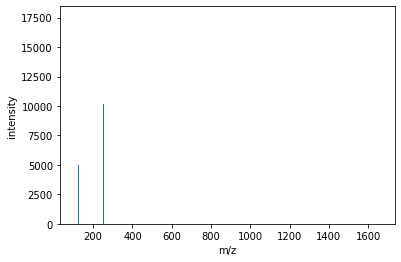

In [20]:
spectrum_index = ms2_retention_times.index(ms2_retention_times[0])
# The width needs to be adjusted for some arrays with extreme peaks.
plt.bar(ms2_mz_arrays[spectrum_index], ms2_intensity_arrays[spectrum_index])
plt.xlabel("m/z")
plt.ylabel("intensity")
plt.show()

## Storing a smaller mzML

In [21]:
from pyopenms import __version__ as pyopenms_version, MzMLFile, MSExperiment, IdXMLFile
print(pyopenms_version)

2.4.0


In [22]:
# Get the mzml file.
DATA_DIR = Path("..").resolve().joinpath("data/")

mzml_file = DATA_DIR.joinpath("1937004_Q1_5.mzML")

# Get IdXML file
idxml_file = DATA_DIR.joinpath("1937004_Q1_5.idXML")

In [23]:
# Storing the MzML content
exp = MSExperiment()
MzMLFile().load(str(mzml_file), exp)

In [24]:
spectrums = []
max_spectrum = 1500

In [25]:
e = MSExperiment()

In [26]:
for i, spec in enumerate(exp):
    if i >= max_spectrum:
        break
    else:
        e.addSpectrum(spec)

MzMLFile().store("smaller.mzML", e)
# print(len(spectrums))

In [27]:
protein_ids = []
peptide_ids = []

IdXMLFile().load(str(idxml_file), protein_ids, peptide_ids)

## Compute the intensity

In [28]:
import seq_to_first_iso as stfi
print(stfi.__version__)

1.1.0


In [29]:
# Analysis on the first peptide
first_RT = peptide_ids[0].getRT()
first_MZ = peptide_ids[0].getMZ()
first_scan = peptide_ids[0].getMetaValue("spectrum_reference").decode()

print(first_RT)
print(first_MZ)
print(first_scan)

362.73063
415.205402217913
controllerType=0 controllerNumber=1 scan=1008


In [30]:
# A mouthful.
first_hit = peptide_ids[0].getHits()[0].getSequence().toString().decode()
print(first_hit)

first_M0_intensity = stfi.compute_M0_nl(mass.Composition(first_hit), stfi.C12_ABUNDANCE)
print(first_M0_intensity)

VQPEDNK
0.9224059861406287


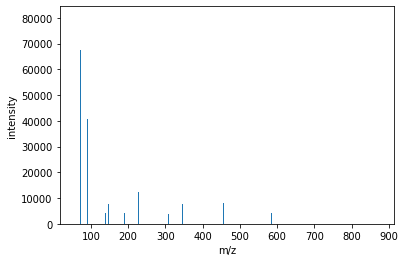

In [31]:
for i, ms2_scan in enumerate(ms2_scans):
    if ms2_scan == first_scan:
        # Assumes same order.
        spectrum_index = ms2_retention_times.index(ms2_retention_times[i])
        # The width needs to be adjusted for some arrays with extreme peaks.
        plt.bar(ms2_mz_arrays[spectrum_index], ms2_intensity_arrays[spectrum_index])
        # Add the hit.  PROBLEM: the intensity is the normalized intensity. 
        plt.bar(first_MZ, first_M0_intensity)
        plt.xlabel("m/z")
        plt.ylabel("intensity")
        plt.show()
        break

## Append data to a HDF5

In [32]:
import pandas as pd  # The pytables dependency is needed
# from collections import defaultdict
import numpy as np

In [33]:
# Convert values to HDF5.  Beware if HDF5 already exists
MS1_values = []
store = pd.HDFStore('store.h5')
chunk_size = 2000

# Supposes intensities and mz have same order.  Iterate over RT.
for i in range(len(ms1_retention_times)):
    # Dict of mz:intensity for MS1 at each recorded RT.  The mz is rounded to avoid too many mz.
    MS1_values.append({round(mz):intensity for mz, intensity in zip(ms1_mz_arrays[i],
                                                                    ms1_intensity_arrays[i])})

    # Dump information in the hdf5 every 2000 elements.
    # HDF5 also has a size limit for the header (column number).
    if i % chunk_size == 0:
        df = pd.DataFrame(MS1_values, index=ms1_retention_times[:i], columns=range(300, 1700, 1))
        # Replace Nan by 0.
        df.fillna(0, inplace=True)
        store.append("df", df)
        MS1_values = []
        # Temporary break.
        if i >= chunk_size:
            break
            
print("HDF5 finished")

HDF5 finished


In [34]:
store.get('df')

,300,301,302,303,304,305,306,307,308,309,...,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699
0.003006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.011141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.017401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.023693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.030447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12.579359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12.586196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12.592467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12.598723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
import vaex

ERROR:MainThread:vaex:issue loading reader
Traceback (most recent call last):
  File "/home/sdv/m2bi/lyang_crosson/.conda/envs/JupyterMS/lib/python3.7/site-packages/vaex/__init__.py", line 720, in <module>
    add_namespace = entry.load()
  File "/home/sdv/m2bi/lyang_crosson/.conda/envs/JupyterMS/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2442, in load
    self.require(*args, **kwargs)
  File "/home/sdv/m2bi/lyang_crosson/.conda/envs/JupyterMS/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2465, in require
    items = working_set.resolve(reqs, env, installer, extras=self.extras)
  File "/home/sdv/m2bi/lyang_crosson/.conda/envs/JupyterMS/lib/python3.7/site-packages/pkg_resources/__init__.py", line 791, in resolve
    raise VersionConflict(dist, req).with_context(dependent_req)
pkg_resources.VersionConflict: (pyarrow 0.11.1 (/home/sdv/m2bi/lyang_crosson/.conda/envs/JupyterMS/lib/python3.7/site-packages), Requirement.parse('pyarrow>=0.15'))


In [36]:
df = vaex.open("store.h5")

ERROR:MainThread:vaex:error opening 'store.h5'


OSError: Could not open file: store.h5, did you install vaex-hdf5? Is the format supported?